# Transcriptomics Data Visualization
#### June 28, 2022

- Explores MERFISH datasets
- Plots cells as points, taking into account gene expression information
- Begins to develop functions for performing PCA on rasterized images including gene expression information

In [2]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import os
import glob
import torch
import pprint

from scipy.stats import rankdata
import nrrd
import time

import tools

import imp
imp.reload(tools)

/nafs/dtward/torch_venv/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses


<module 'tools' from '/ifshome/oamiuwu/rasterization_work/tools.py'>

In [3]:
#grabs metadata files
meta_files = glob.glob('/ifshome/dtward/data/merfish/jean_fan_2021/OneDrive_1_8-5-2021/*metadata*.csv.gz')
meta_files.sort()

#grabs "by_gene" files
gene_files = glob.glob('/ifshome/dtward/data/merfish/jean_fan_2021/OneDrive_1_8-5-2021/*by_gene*.csv.gz')
gene_files.sort()

pprint.pprint(meta_files)

['/ifshome/dtward/data/merfish/jean_fan_2021/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate1_cell_metadata_S1R1.csv.gz',
 '/ifshome/dtward/data/merfish/jean_fan_2021/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate2_cell_metadata_S1R2.csv.gz',
 '/ifshome/dtward/data/merfish/jean_fan_2021/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate3_cell_metadata_S1R3.csv.gz',
 '/ifshome/dtward/data/merfish/jean_fan_2021/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate1_cell_metadata_S2R1.csv.gz',
 '/ifshome/dtward/data/merfish/jean_fan_2021/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate2_cell_metadata_S2R2.csv.gz',
 '/ifshome/dtward/data/merfish/jean_fan_2021/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_cell_metadata_S2R3.csv.gz',
 '/ifshome/dtward/data/merfish/jean_fan_2021/OneDriv

<IPython.core.display.Javascript object>


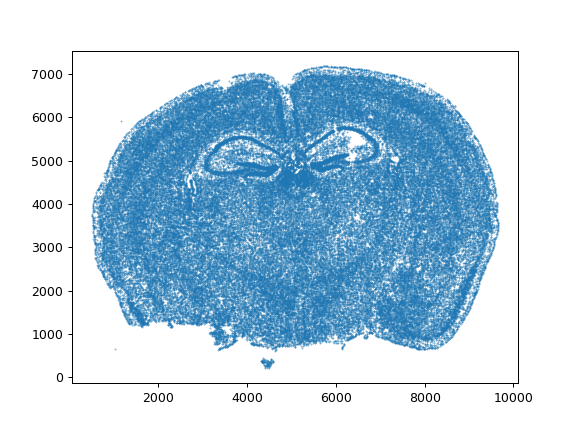

In [4]:
# indices 0-2: axial, 3-5: coronal, 6-8: sagittal (NO ALL CORONAL)
fname = meta_files[5]

df_meta = pd.read_csv(fname)

#displays scatterplot of one of the slices
fig, ax = plt.subplots()
ax.scatter(np.array(df_meta['center_x']), np.array(df_meta['center_y']), s=.3**2)
plt.show()

#loops are dentate gyrus

In [7]:
#checks that IDs for metadata df and gene df are in the same order
df_gene = pd.read_csv(gene_files[-4])

for i in range(len(df_gene)):
    if df_gene["Unnamed: 0"][i] !=  df_meta["Unnamed: 0"][i]:
        print("IDs need to be sorted.")
print("Done")

Done


In [8]:
#function that creates new colormap from built-in colormap with white at the beginning
#ensures all points with 0 gene expression do not appear in image

def create_cmap(cmap_name='viridis'):
    
    prev_cmap = cm.get_cmap(cmap_name, 256)
    newcolors = prev_cmap(np.linspace(0, 1, 256))
    white = np.array([1, 1, 1, 0]) #final number is transparency/opacity
    newcolors[:1:] = white
    return ListedColormap(newcolors)

<IPython.core.display.Javascript object>


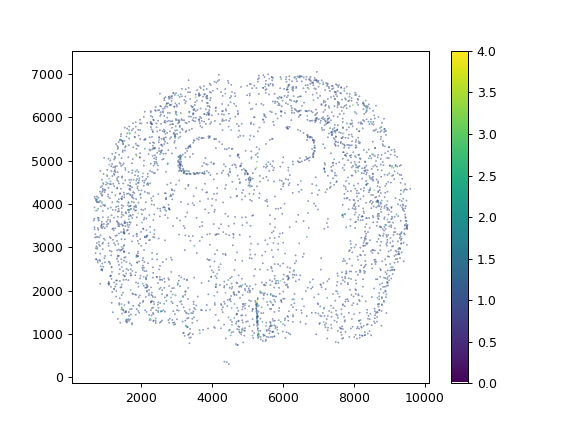

In [9]:
#list of gene names, without ID or blanks
genes = list(df_gene.columns)[1:484]

#displays scatterplot of one slice with the color depending on gene expression level from "___"
fig, ax = plt.subplots()
h = ax.scatter(np.array(df_meta['center_x']), np.array(df_meta['center_y']), 
               s=.3**2, c=np.array(df_gene[genes[0]]), cmap=create_cmap("viridis"))

plt.colorbar(mappable=h)

plt.show()

#visualize multiple genes at once with colorbar
#try to spot patterns
#read tools.rasterize documentaiton (create gaussian blob centered in each cell
#modify function to input gene expression)

<IPython.core.display.Javascript object>


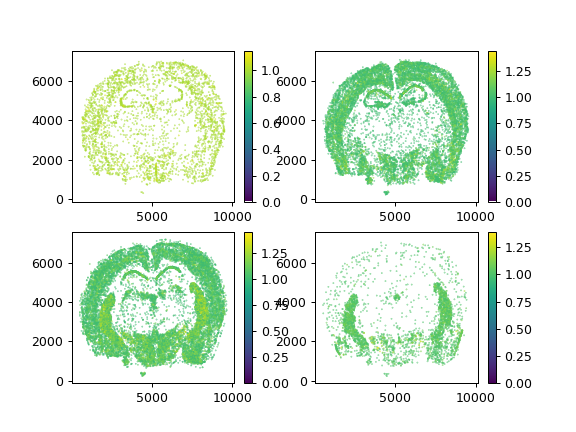

In [10]:
genes = list(df_gene.columns)
genes = genes[1:484]

#grid of scatter plots representing gene expression from different genes
fig, ax = plt.subplots(nrows=2, ncols=2)

power = 0.1

a = ax[0][0].scatter(np.array(df_meta['center_x']), np.array(df_meta['center_y']), 
               s=.3**2, c=np.array(df_gene[genes[0]])**power, cmap=create_cmap("viridis"))
b = ax[0][1].scatter(np.array(df_meta['center_x']), np.array(df_meta['center_y']), 
               s=.3**2, c=np.array(df_gene[genes[1]])**power, cmap=create_cmap("viridis"))
c = ax[1][0].scatter(np.array(df_meta['center_x']), np.array(df_meta['center_y']), 
               s=.3**2, c=np.array(df_gene[genes[2]])**power, cmap=create_cmap("viridis"))
d = ax[1][1].scatter(np.array(df_meta['center_x']), np.array(df_meta['center_y']), 
               s=.3**2, c=np.array(df_gene[genes[3]])**power, cmap=create_cmap("viridis"))

plt.colorbar(mappable=a, ax=ax[0][0])
plt.colorbar(mappable=b, ax=ax[0][1])
plt.colorbar(mappable=c, ax=ax[1][0])
plt.colorbar(mappable=d, ax=ax[1][1])

plt.show()

#interpret values in terms of ordering, not magnitude

<IPython.core.display.Javascript object>


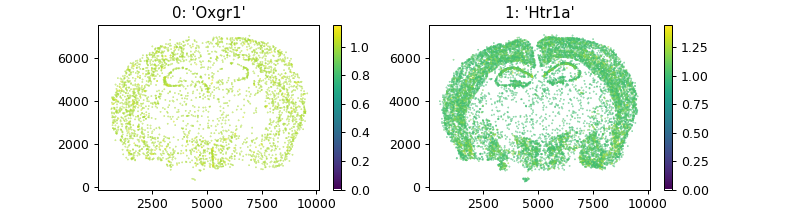

In [31]:
#Takes in list of indices
#Displays a figure with gene expression scatter plots for the gene represented by each index
#Note: list must have even length

def show_plots(gene_index: list) -> None:
    
    power = 0.1
    if len(gene_index) % 2 != 0:
        raise ValueError("The list must have an even number of entries.")
    
    n = len(gene_index) // 2
    fig, ax = plt.subplots(nrows=n, ncols=2, squeeze=False)
    for i in range(n):
        for j in range(2):
            index = gene_index[2*i+j]
            h = ax[i][j].scatter(np.array(df_meta['center_x']), np.array(df_meta['center_y']), 
                             s=.3**2, c=np.array(df_gene[genes[index]])**power, cmap=create_cmap("viridis"))
            ax[i][j].title.set_text("%s: \'%s\'" %(index, genes[index]))
            plt.colorbar(mappable=h, ax=ax[i][j])
    
    plt.show()

show_plots(range(2))

#for each gene, calculate mean for counts subtract mean and divide std (z-score)
#apply gamma correction. take data and apply a power
#monotomic transmortion

In [9]:
genes[83]
df_gene['Cnr1']

0         0.0
1        78.0
2         0.0
3         0.0
4         0.0
         ... 
85953     0.0
85954     0.0
85955     0.0
85956     0.0
85957     0.0
Name: Cnr1, Length: 85958, dtype: float64

In [10]:
cell = 241

count = np.unique(df_gene[genes[cell]]) #gives array of unique values of gene expression levels
count_arr = np.bincount(df_gene[genes[cell]]) #gives array of the number of occurences of a gene expression value
count_arr

array([25696, 14346,  9281,  6887,  5191,  4121,  3482,  2754,  2378,
        1974,  1616,  1279,  1092,   939,   786,   650,   572,   510,
         380,   321,   250,   223,   206,   148,   119,   122,    92,
          80,    81,    55,    48,    38,    39,    33,    32,    25,
           7,    19,    16,    15,    11,     6,    10,     2,     4,
           2,     2,     5,     1,     4,     0,     1,     3,     0,
           1,     1,     0,     0,     0,     0,     0,     0,     1,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     1])

<IPython.core.display.Javascript object>


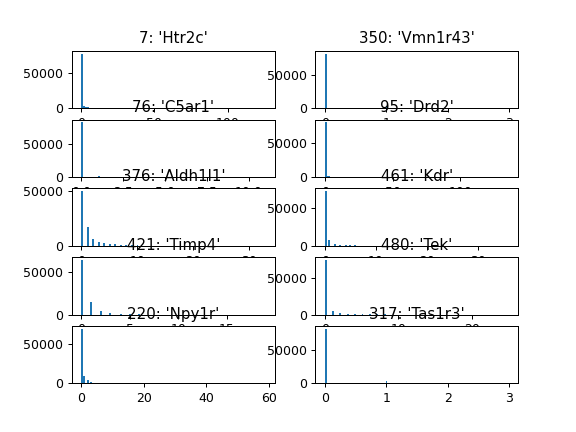

In [11]:
def show_histograms() -> None:
    
    temp = np.random.randint(low=0, high=482, size=10)
    n = 5
    fig, ax = plt.subplots(nrows=n, ncols=2, squeeze=False)
    
    for i in range(n):
        for j in range(2):
            index = temp[2*i+j]
            ax[i][j].hist(df_gene[genes[index]],100)
            ax[i][j].title.set_text("%s: \'%s\'" %(index, genes[index]))
    
    plt.show()

show_histograms()

<IPython.core.display.Javascript object>


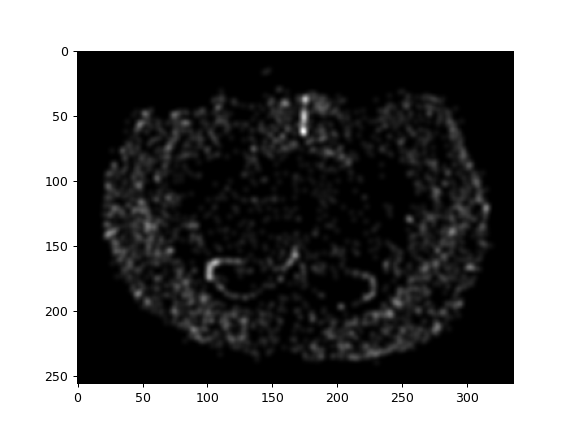

0 of 85958


/ifshome/oamiuwu/rasterization_work/tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  toshow = toshow / np.max(toshow,axis=(0,1),keepdims=True)


10000 of 85958
20000 of 85958
30000 of 85958
40000 of 85958
50000 of 85958
60000 of 85958
70000 of 85958
80000 of 85958
85957 of 85958


In [12]:
xI = np.array(df_meta['center_x'])
yI = np.array(df_meta['center_y'])
gI = np.array(df_gene[genes[0]])


imp.reload(tools)
blur = 1.0

draw = 10000
wavelet_magnitude = True
dx = 30.0
use_windowing = True
XI,YI,I,fig = tools.rasterize(xI,yI,gI,dx=dx,blur=blur,expand=1.1, draw=draw, wavelet_magnitude=wavelet_magnitude, 
                              use_windowing=use_windowing)


In [13]:
#Performing PCA
def pca(n=3):
    
    xI = np.array(df_meta['center_x'])
    yI = np.array(df_meta['center_y'])
    
    for i in range(n):
        gI = np.array(df_gene[genes[i]])
        XI,YI,I = tools.rasterize(xI,yI,gI,dx=dx,blur=blur,expand=1.1, draw=0, 
                              wavelet_magnitude=True, use_windowing=True)
        
        if(i==0):
            X = np.empty([n, YI.size, XI.size])
            Y = np.empty([n, XI.size*YI.size])
        
        X[i] = np.array(I)
        print(X[i].shape)
        I_ = I.ravel()
        meanI = np.mean(I_)
        I_ -= meanI
        Y[i] = I_
        
    S = np.cov(Y) #same as (Y @ Y.T)/Y.shape[1]
    return X,Y,S

X,Y,S = pca()

(256, 336)
(256, 336)
(256, 336)


<IPython.core.display.Javascript object>


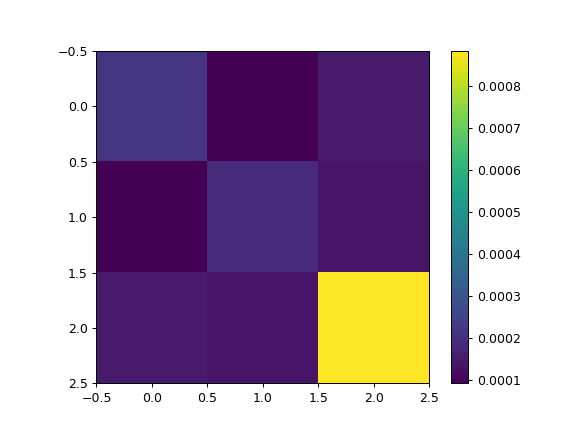

In [14]:
#plots covariance matrix
fig,ax = plt.subplots()
h = ax.imshow(S)
plt.colorbar(mappable=h)

In [15]:
def pca2(S):
    W,V = np.linalg.eigh(S)
    
    W = W[::-1] #descending order
    V = V[:,::-1] #keep eigenvectors and eigenvalues paired
    return W,V
    
W,V = pca2(S)


<IPython.core.display.Javascript object>


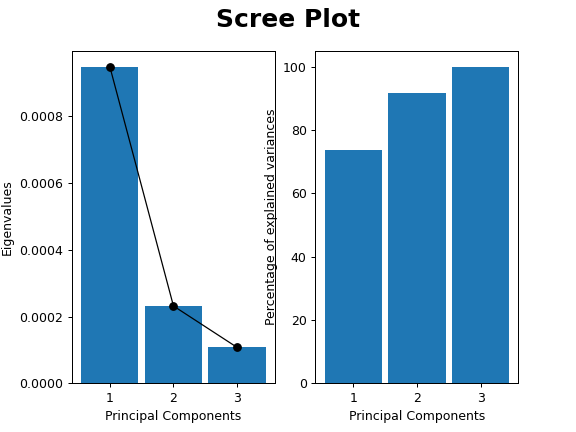

Text(0, 0.5, 'Percentage of explained variances')

In [16]:
#Creates scree plot
W_ = np.cumsum(W)/np.sum(W)*100
fig, ax = plt.subplots(1,2)
ax[0].bar(range(3),W,width=.9,tick_label=range(1,4))
ax[0].plot(W,'ko-',linewidth=1)

ax[1].bar(range(3),W_,width=.9,tick_label=range(1,4))
#ax[1].plot(W_,'ko-',linewidth=1)

fig.suptitle("Scree Plot", fontsize=20,fontweight='bold')
ax[0].set_xlabel('Principal Components')
ax[0].set_ylabel("Eigenvalues")
ax[1].set_xlabel('Principal Components')
ax[1].set_ylabel("Percentage of explained variances")


In [17]:
def pca3(W,V,Y):
    """W_ = W/np.sum(W)*100
    
    total = W_[0]
    L = 1
    while total < 90:
        total += W_[L]
        L+=1
    
    V_ = V[:,:L]"""
    
    Z = V.T @ Y
    return Z

Z = pca3(W,V,Y)
I.shape

(1, 256, 336)

<IPython.core.display.Javascript object>


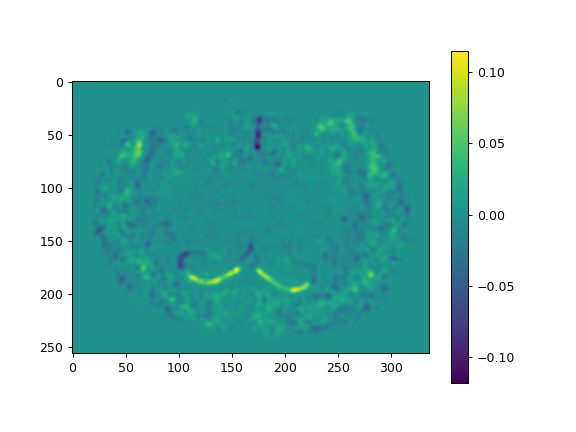

In [18]:
I_pca = Z.reshape((Z.shape[0], I.shape[1], I.shape[2]))
fig,ax = plt.subplots()
h = ax.imshow(I_pca[-1])
plt.colorbar(mappable=h)

In [19]:
I_pca.shape

(3, 256, 336)

<IPython.core.display.Javascript object>


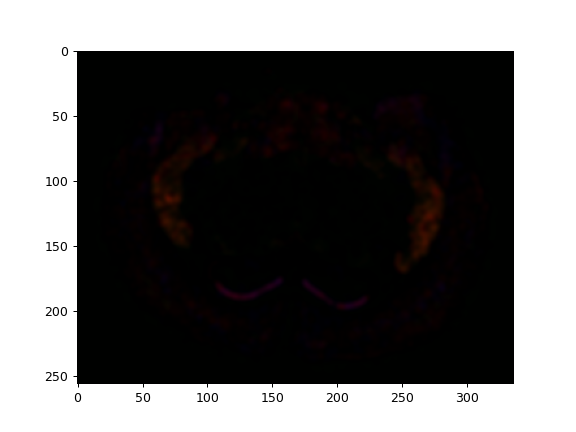

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [20]:
I_rgb = np.array(I_pca[:3].transpose(1,2,0))
fig,ax = plt.subplots()
h = ax.imshow(I_rgb)

Next steps
- normalize rgb values
- save I_pca and I.rgb and Z (np.savez)
- modularize pca function (documentation on normalization function too) 
- do all genes
- run for every image and save figures